## * This TA class note is based on Jeong Hwan Lee's TAO-2022 TA class note.

# Exercise: SExtractor Photometry of a Galaxy Cluster

* Purpose of this exercise: Let's find sources in the images and plot a color-magnitude diagram
    * Example galaxy cluster: $\color{blue}{\text{MACS J0717.5+3745}}$ (z=0.545)
    * Filters: HST/ACS F606W(V) and F814W(I)
    * There are two FITS images: M0717_F606W.fits, M0717_F814W.fits
</br></br>
* Process: Extract sources &rarr; classify stars & galaxies &rarr; draw color-magnitude diagrams of the galaxies

## - What is Source Extractor (SExtractor)?
* A program for automated detection and photometry of sources in FITS image files (Bertin & Arnouts 1996)
    * webpage: https://www.astromatic.net/software/sextractor
* Specialized for reduction of large-scale galaxy survey data but can perform reasonably well on moderately crowded star fields.
* Manuals:
    * User's Manual ver.2.13 - E. Bertin (difficult to follow for beginners)
    * SExtractor for Dummies - B. Holwerda (a friendlier version)

## - Running SExtractor
* Input files: FITS image, configuration file, parameter file
* Output files: source catalog, FITS check images
* running command: sextractor $\color{blue}{\text{[FITS image]}}$ -c $\color{red}{\text{[configuration file]}}$ -[output parameter1][value1] -[output parameter2][value2] ...
    * Ex) sextractor $\color{blue}{\text{M0717\_F814W.fits}}$ -c $\color{red}{\text{config.txt}}$ -CATALOG_NAME 814.cat (...)

## - Input parameters
* $\color{blue}{\textbf{FITS image:}}$ single extension or multi-extension</br></br>
* $\color{red}{\textbf{Configuration file:}}$ list of parameters and their values given by the user
    * example is given by '/usr/share/sextractor/default.sex' (it is a default configuration file)
    * Catalog:
        * CATALOG_NAME: name of the output catalog (*.cat)
        * PARAMETERS_NAME: name of the file containing catalog contents (*.param)
    * Extraction:
        * DETECT_MINAREA: min. # of pixels above threshold &rarr; 5(default)
        * DETECT_THRESH: 1.5$\sigma$ (default)
        * ANALYSIS_THRESH: 1.5$\sigma$ (usually same as DETECT_THRESH)
    * Photometry:
        * SATUR_LEVEL: pixel level above which it is considered saturated
        * MAG_ZEROPOINT: magnitude zero point
        * GAIN: effective gain [e-/ADU] (only affects the magnitude error)
        * PIXEL_SCALE: [arcsec/pixel]
    * Star/Galaxy Separation:
        * SEEING_FWHM: FWHM of stars in arcsec (use DAOPHOT/imexam to estimate)
    * Background:
        * BACK_SIZE: set size of background mesh for background estimation [pixels]
    * Check Image:
        * CHECKIMAGE_TYPE: types of check images to output (recommended: APERTURES)
        * CHECKIMAGE_NAME: names of check images</br></br>
        
* $\textbf{Parameter file:}$ list of parameters to extract to output catalog
    * check '/usr/share/sextractor/default.param' for explanations of each parameter (total 400 parameters)
    * one column consisting of the parameter names</br>
        X_IMAGE</br>
        Y_IMAGE</br>
        NUMBER</br>
        MAG_AUTO</br>
        MAGERR_AUTO</br>
        ...

In [1]:
# read default configuration file: '/usr/share/sextractor/default.sex'

for line in open('/usr/share/sextractor/default.sex', 'r').readlines():
    line = line.strip()
    print(line)

# Default configuration file for SExtractor 2.12.4
# EB 2010-10-10
#

#-------------------------------- Catalog ------------------------------------

CATALOG_NAME     test.cat       # name of the output catalog
CATALOG_TYPE     ASCII_HEAD     # NONE,ASCII,ASCII_HEAD, ASCII_SKYCAT,
# ASCII_VOTABLE, FITS_1.0 or FITS_LDAC
PARAMETERS_NAME  default.param  # name of the file containing catalog contents

#------------------------------- Extraction ----------------------------------

DETECT_TYPE      CCD            # CCD (linear) or PHOTO (with gamma correction)
DETECT_MINAREA   3              # min. # of pixels above threshold

DETECT_THRESH    1.5            # <sigmas> or <threshold>,<ZP> in mag.arcsec-2
ANALYSIS_THRESH  1.5            # <sigmas> or <threshold>,<ZP> in mag.arcsec-2

FILTER           Y              # apply filter for detection (Y or N)?
FILTER_NAME      default.conv   # name of the file containing the filter

DEBLEND_NTHRESH  32             # Number of deblending sub-threshol

In [2]:
# read parameter list file: '/usr/share/sextractor/default.param'

for line in open('/usr/share/sextractor/default.param', 'r').readlines():
    line = line.strip()
    print(line)

#NUMBER                   Running object number
#EXT_NUMBER               FITS extension number
#FLUX_ISO                 Isophotal flux                                            [count]
#FLUXERR_ISO              RMS error for isophotal flux                              [count]
#MAG_ISO                  Isophotal magnitude                                       [mag]
#MAGERR_ISO               RMS error for isophotal magnitude                         [mag]
#FLUX_ISOCOR              Corrected isophotal flux                                  [count]
#FLUXERR_ISOCOR           RMS error for corrected isophotal flux                    [count]
#MAG_ISOCOR               Corrected isophotal magnitude                             [mag]
#MAGERR_ISOCOR            RMS error for corrected isophotal magnitude               [mag]
#FLUX_APER                Flux vector within fixed circular aperture(s)             [count]
#FLUXERR_APER             RMS error vector for aperture flux(es)                    

## - Output parameters

* $\textbf{Source catalog}$
* $\textbf{FITS check images}$
* $\textbf{CLASS\_STAR:}$ can be used to separate point sources and extended sources

# 0. Importing Necessary Packages

In [3]:
# Printing the versions of packages
from importlib_metadata import version
for pkg in ['numpy', 'matplotlib', 'astropy', 'pandas']:
    print(pkg+": ver "+version(pkg))

numpy: ver 1.21.2
matplotlib: ver 3.5.0
astropy: ver 5.0.1
pandas: ver 1.3.4


In [4]:
# matplotlib backend
%matplotlib notebook

# importing necessary modules
import numpy as np
import glob, os
from matplotlib import pyplot as plt
from astropy.io import fits
from astropy.visualization import ZScaleInterval
import pandas as pd

In [5]:
command = 'sextractor' # or use 'sex'. This depends on your installation.

# 1. Writing Input Files

### 1) Image list

In [6]:
dir_img = "Images/"
band = ["F606W", "F814W"]
imglist = sorted(glob.glob(dir_img+"*.fits"))
imglist

['Images/M0717_F606W.fits', 'Images/M0717_F814W.fits']

OMP: Warning #182: OMP_STACKSIZE: ignored because KMP_STACKSIZE has been defined
OMP: Warning #182: GOMP_STACKSIZE: ignored because KMP_STACKSIZE has been defined


<IPython.core.display.Javascript object>


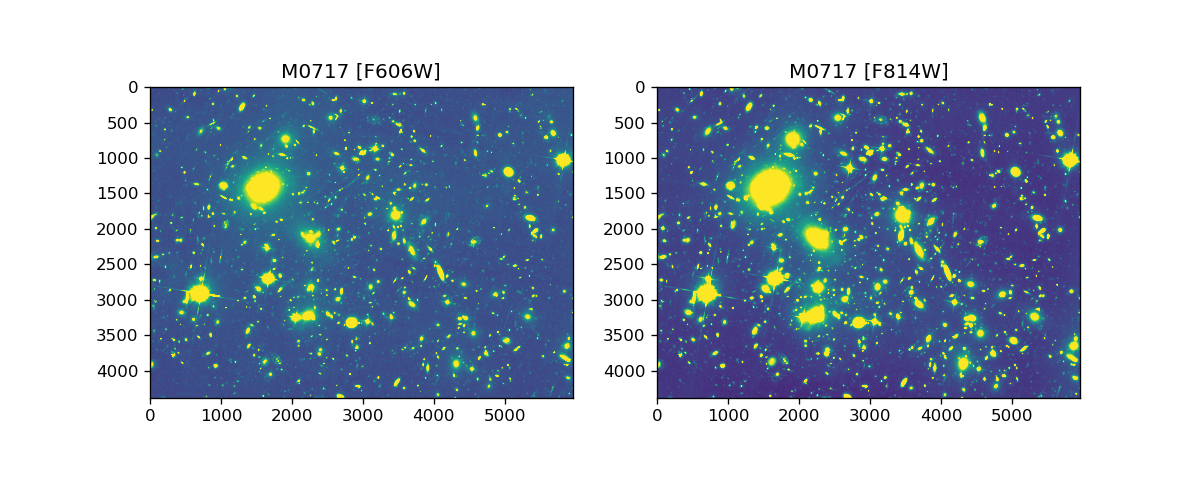

In [7]:
hdu_606 = fits.open(imglist[0])
hdu_814 = fits.open(imglist[1])

interval = ZScaleInterval()
vmin_606, vmax_606 = interval.get_limits(hdu_606[0].data)
vmin_814, vmax_814 = interval.get_limits(hdu_814[0].data)

fig, axes = plt.subplots(1,2, figsize=(10, 4))
axes[0].imshow(hdu_606[0].data, vmin=vmin_606, vmax=vmax_606)
axes[0].set_title('M0717 [F606W]')
axes[1].imshow(hdu_814[0].data, vmin=vmin_814, vmax=vmax_814)
axes[1].set_title('M0717 [F814W]')
plt.show()

### 2) Configuration file

In [8]:
config_name = "config.txt"
os.system(command+" -dd > "+config_name)

0

### 3) Output parameter file

In [9]:
param_name = "output.param"
f = open(param_name, "w")
f.write("X_IMAGE\n")    # Object position along x [pixel]
f.write("Y_IMAGE\n")    # Object position along y [pixel]
f.write("NUMBER\n")    # Object number
f.write("MAG_AUTO\n")    # Kron-like elliptical aperture magnitude [mag]
f.write("MAGERR_AUTO\n")    # RMS error for MAG_AUTO    [mag]
f.write("KRON_RADIUS\n")    # Kron apertures in units of A or B
f.write("BACKGROUND\n")    # Background at centroid position
f.write("ALPHA_J2000\n")    # Right ascension of object center (J2000)
f.write("DELTA_J2000\n")    # Declination of object center (J2000)
f.write("A_IMAGE\n")    # Along major axis
f.write("B_IMAGE\n")    # Along minor axis
f.write("THETA_IMAGE\n")    # Position angle
f.write("MU_MAX\n")    # Peak surface brightness above background
f.write("FLAGS\n")    # Extraction flags
f.write("FWHM_IMAGE\n")    # FWHM assuming a gaussian core
f.write("FLUX_RADIUS\n")    # Half-light radii
f.write("CLASS_STAR\n")    # Star/Galaxy classifier output
f.close()

### 4) Determining input parameters

In [10]:
h606 = fits.getheader(imglist[0])
h814 = fits.getheader(imglist[1])

In [11]:
# band = ["F606W", "F814W"]
cat_name = ["606.cat", "814.cat"]
detect_minarea = 5  # DETECT_MINAREA = 5 (default)
detect_thresh = 1.5  # DETECT_THRESH = 1.5 (default)
saturated = 100.0  # SATUR_LEVEL = 100.0 (depending on the image!)
mag0 = [-2.5*np.log10(h606['PHOTFLAM'])-5.0*np.log10(h606['PHOTPLAM'])-2.408,
        -2.5*np.log10(h814['PHOTFLAM'])-5.0*np.log10(h814['PHOTPLAM'])-2.408]
egain = [h606['CCDGAIN']*h606['EXPTIME'], h814['CCDGAIN']*h814['EXPTIME']]
# GAIN (effective gain) = gain*exptime (for c/s image) --> this parameter only affects the magnitude error value!
pixel_scale = 0.03  # arcsec/pixel
fwhm = [0.09, 0.09]  # For HST images, seeing FWHMs are typically 3 pixels (~ 0.09 arcsec).
# However, you can directly measure the FWHM value in your image using imexamine or etc.,
# because the FWHM value can also vary with image quality.
back_size = 32  # BACK_SIZE = 64 (default) --> 32 (revised)
# Smaller BACK_SIZE --> Can subtract more local background --> Can detect more sources
checkimg = ["606_aper.fits", "814_aper.fits"]  # CHECKIMAGE_NAME (apertures)
refimg = imglist[1]

### 5) Shell script for SExtractor photometry

### - Importance of Dual-mode photometry

* Number of detected sources are different between the two filters.
* Shape and size of aperture is different for identical sources in different filter images (if MAG_AUTO is used).
* To compute colors, it is important to run SExtractor in $\color{blue}{\rm dual\:mode}$.

### - Running SExtractor in Dual mode

* running command: sex [detection image], [photometry image] -c [configuration file]
    * Detection image: reference image with all the detected sources (image with longer exposure time and better quality)
    * Photometry image: image to perform photometry on</br></br>

* Filter with longest exposure time for project = F814W = detection image
* Or you can create a new detection image with F606W+F814W</br></br>

* running command Ex) 
    * sextractor [F814W image] -c [F814W configuration file]
    * sextractor [F606W image] -c [F606W configuration file] $\color{blue}{\rm \#\:single\:mode}$
    * sextractor [F814W image],[F606W image] -c [F606W configuration file] $\color{blue}{\rm \#\:dual\:mode}$

In [12]:
scr_name = "sephot.sh"
f = open(scr_name, "w")
for i in np.arange(len(band)):
    
    # Reference image
    if (imglist[i] == refimg):
        txt = command+" "+imglist[i]+" -c config.txt -CATALOG_NAME "+cat_name[i]+" -PARAMETERS_NAME output.param "

    # Non-reference image
    else:
        txt = command+" "+refimg+","+imglist[i]+" -c config.txt -CATALOG_NAME "+cat_name[i]+" -PARAMETERS_NAME output.param "

    txt += f"-DETECT_MINAREA {detect_minarea:d} -DETECT_THRESH {detect_thresh:.1f} "
    txt += f"-FILTER_NAME /usr/share/sextractor/default.conv -SATUR_LEVEL {saturated:.1f} "
    txt += f"-MAG_ZEROPOINT {mag0[i]:.4f} -GAIN {egain[i]:.2f} -PIXEL_SCALE {pixel_scale:.2f} "
    txt += f"-SEEING_FWHM {fwhm[i]:.2f} -STARNNW_NAME /usr/share/sextractor/default.nnw -BACK_SIZE {back_size:d} "
    txt += "-CHECKIMAGE_TYPE APERTURES -CHECKIMAGE_NAME "+checkimg[i]
    txt += "\n"
    
    f.write(txt)
    
f.close()

# 2. Running SExtractor

In [13]:
os.system("sh sephot.sh")
# Run this and see the terminal where the Jupyter Notebook is open!

> 
----- SExtractor 2.19.5 started on 2023-04-24 at 20:09:28 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing check-image(s)
> Initializing catalog
> Looking for M0717_F814W.fits
----- Detecting from: M0717_F814W.fits
      "Unnamed" / no ext. header / 5961x4381 / 32 bits (floats)
> Looking for M0717_F606W.fits
----- Measuring from: M0717_F606W.fits
      "Unnamed" / no ext. header / 5961x4381 / 32 bits (floats)
Measurement image:> Setting up background maps
> Setting up background map at line:   32
> Setting up background map at line:   64
> Setting up background map at line:   96
> Setting up background map at line:  128
> Setting up background map at line:  160
> Setting up background map at line:  192
> Setting up background map at line:  224
> Setting up background map at line:  256
> Setting up background map at line:  288
> Setting up background map at line:  320
> Setting up back

> Setting up background map at line: 1952
> Setting up background map at line: 1984
> Setting up background map at line: 2016
> Setting up background map at line: 2048
> Setting up background map at line: 2080
> Setting up background map at line: 2112
> Setting up background map at line: 2144
> Setting up background map at line: 2176
> Setting up background map at line: 2208
> Setting up background map at line: 2240
> Setting up background map at line: 2272
> Setting up background map at line: 2304
> Setting up background map at line: 2336
> Setting up background map at line: 2368
> Setting up background map at line: 2400
> Setting up background map at line: 2432
> Setting up background map at line: 2464
> Setting up background map at line: 2496
> Setting up background map at line: 2528
> Setting up background map at line: 2560
> Setting up background map at line: 2592
> Setting up background map at line: 2624
> Setting up background map at line: 2656
> Setting up background map at lin

> Line: 1575  Objects:     5301 detected /      996 sextracted
> Line: 1600  Objects:     5397 detected /     1033 sextracted
> Line: 1625  Objects:     5528 detected /     1086 sextracted
> Line: 1650  Objects:     5630 detected /     1127 sextracted
> Line: 1675  Objects:     5715 detected /     1172 sextracted
> Line: 1691  Objects:     5751 detected /     1200 sextracted
> Line: 1700  Objects:     5782 detected /     1213 sextracted
> Line: 1725  Objects:     5855 detected /     1259 sextracted
> Line: 1750  Objects:     5936 detected /     1297 sextracted
> Line: 1775  Objects:     5999 detected /     1339 sextracted
> Line: 1800  Objects:     6095 detected /     1372 sextracted
> Line: 1825  Objects:     6181 detected /     1404 sextracted
> Line: 1850  Objects:     6305 detected /     1442 sextracted
> Line: 1875  Objects:     6397 detected /     1478 sextracted
> Line: 1900  Objects:     6485 detected /     1521 sextracted
> Line: 1925  Objects:     6591 detected /     1560 sex

> Line: 4275  Objects:    14525 detected /     5508 sextracted
> Line: 4300  Objects:    14599 detected /     5539 sextracted
> Line: 4325  Objects:    14668 detected /     5577 sextracted
> Line: 4341  Objects:    14718 detected /     5600 sextracted
> Line: 4350  Objects:    14735 detected /     5613 sextracted
> Line: 4375  Objects:    14804 detected /     5663 sextracted
> Line: 4381  Objects:    14858 detected /     6000 sextracted
> Line: 4381  Objects:    14858 detected /     6400 sextracted
> Line: 4381  Objects:    14858 detected /     6800 sextracted
> Line: 4381  Objects:    14858 detected /     7200 sextracted
      Objects: detected 14858    / sextracted 7241            

> Closing files
> 
> All done (in 6.1 s: 715.8 lines/s , 1183.1 detections/s)
> 
----- SExtractor 2.19.5 started on 2023-04-24 at 20:09:34 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing check-image(s)
> I

> Line:  300  Objects:      912 detected /        0 sextracted
> Line:  325  Objects:      967 detected /        0 sextracted
> Line:  350  Objects:     1053 detected /        0 sextracted
> Line:  375  Objects:     1127 detected /        0 sextracted
> Line:  400  Objects:     1206 detected /        0 sextracted
> Line:  425  Objects:     1296 detected /        0 sextracted
> Line:  450  Objects:     1377 detected /        0 sextracted
> Line:  475  Objects:     1451 detected /        0 sextracted
> Line:  500  Objects:     1539 detected /        0 sextracted
> Line:  525  Objects:     1611 detected /        0 sextracted
> Line:  550  Objects:     1681 detected /        0 sextracted
> Line:  575  Objects:     1776 detected /        0 sextracted
> Line:  600  Objects:     1851 detected /        0 sextracted
> Line:  625  Objects:     1933 detected /        0 sextracted
> Line:  650  Objects:     2029 detected /        0 sextracted
> Line:  675  Objects:     2146 detected /        0 sex

> Line: 3025  Objects:    10318 detected /     3591 sextracted
> Line: 3032  Objects:    10342 detected /     3600 sextracted
> Line: 3050  Objects:    10405 detected /     3625 sextracted
> Line: 3075  Objects:    10523 detected /     3664 sextracted
> Line: 3100  Objects:    10610 detected /     3694 sextracted
> Line: 3125  Objects:    10687 detected /     3739 sextracted
> Line: 3150  Objects:    10803 detected /     3782 sextracted
> Line: 3175  Objects:    10909 detected /     3827 sextracted
> Line: 3200  Objects:    11015 detected /     3863 sextracted
> Line: 3225  Objects:    11133 detected /     3901 sextracted
> Line: 3250  Objects:    11251 detected /     3945 sextracted
> Line: 3275  Objects:    11342 detected /     3979 sextracted
> Line: 3284  Objects:    11370 detected /     4000 sextracted
> Line: 3300  Objects:    11411 detected /     4028 sextracted
> Line: 3325  Objects:    11505 detected /     4064 sextracted
> Line: 3350  Objects:    11584 detected /     4112 sex

0

# 3. Reading the Data

In [14]:
colnames = ['x','y','num','mag','merr','kron','backgr','ra','dec',
            'a','b','theta','mu0','flag','fwhm','flxrad','cl']
dat_V = np.genfromtxt(cat_name[0], dtype=None, encoding='ascii', names=colnames)
dat_I = np.genfromtxt(cat_name[1], dtype=None, encoding='ascii', names=colnames)

In [15]:
pd.DataFrame(dat_V).head(5)

x         y  num      mag    merr  kron    backgr          ra  \
0  1911.3966  731.6298    1  21.6796  0.0016  3.50  0.008239  109.418494   
1  5889.4160  712.3062    2  25.0527  0.0258  5.07  0.000524  109.376589   
2  4584.9277  434.9285    3  21.8951  0.0017  3.50  0.004010  109.390331   
3  2690.8933  337.5047    4  23.0958  0.0032  3.50  0.001310  109.410282   
4  1297.1003  281.1276    5  21.8859  0.0022  3.50  0.008271  109.424964   

         dec       a       b  theta      mu0  flag    fwhm  flxrad     cl  
0  37.714342  19.341  17.623   0.44  20.1833     2    9.84  15.628  0.029  
1  37.714185  38.863   2.462 -79.74  24.3301    19   58.72  90.449  0.000  
2  37.711874  21.432  12.511  72.92  19.8551     0   13.37  10.840  0.029  
3  37.711060  15.863   6.663 -87.72  20.8277     0    8.63   9.864  0.029  
4  37.710586  33.888  13.639 -61.65  21.7182     0  111.26  27.440  0.001

In [16]:
pd.DataFrame(dat_I).head(5)

x         y  num      mag    merr  kron    backgr          ra  \
0  1911.3966  731.6298    1  20.1743  0.0004  3.50  0.016663  109.418494   
1  5889.4160  712.3062    2  24.5668  0.0140  5.07  0.000402  109.376589   
2  4584.9277  434.9285    3  20.5084  0.0004  3.50  0.007200  109.390331   
3  2690.8933  337.5047    4  21.7658  0.0008  3.50  0.001527  109.410282   
4  1297.1003  281.1276    5  21.3095  0.0011  3.50  0.008162  109.424964   

         dec       a       b  theta      mu0  flag   fwhm  flxrad     cl  
0  37.714342  19.341  17.623   0.44  18.7318     2  10.11  16.039  0.029  
1  37.714185  38.863   2.462 -79.74  23.9554    19  58.72  40.278  0.000  
2  37.711874  21.432  12.511  72.92  18.6067     0  13.36  12.136  0.029  
3  37.711060  15.863   6.663 -87.72  19.4696     0   8.54   9.882  0.029  
4  37.710586  33.888  13.639 -61.65  20.9812     0  73.93  26.175  0.029

# 4. Plotting the Figures

### 0) Check image - APERTURES

<IPython.core.display.Javascript object>


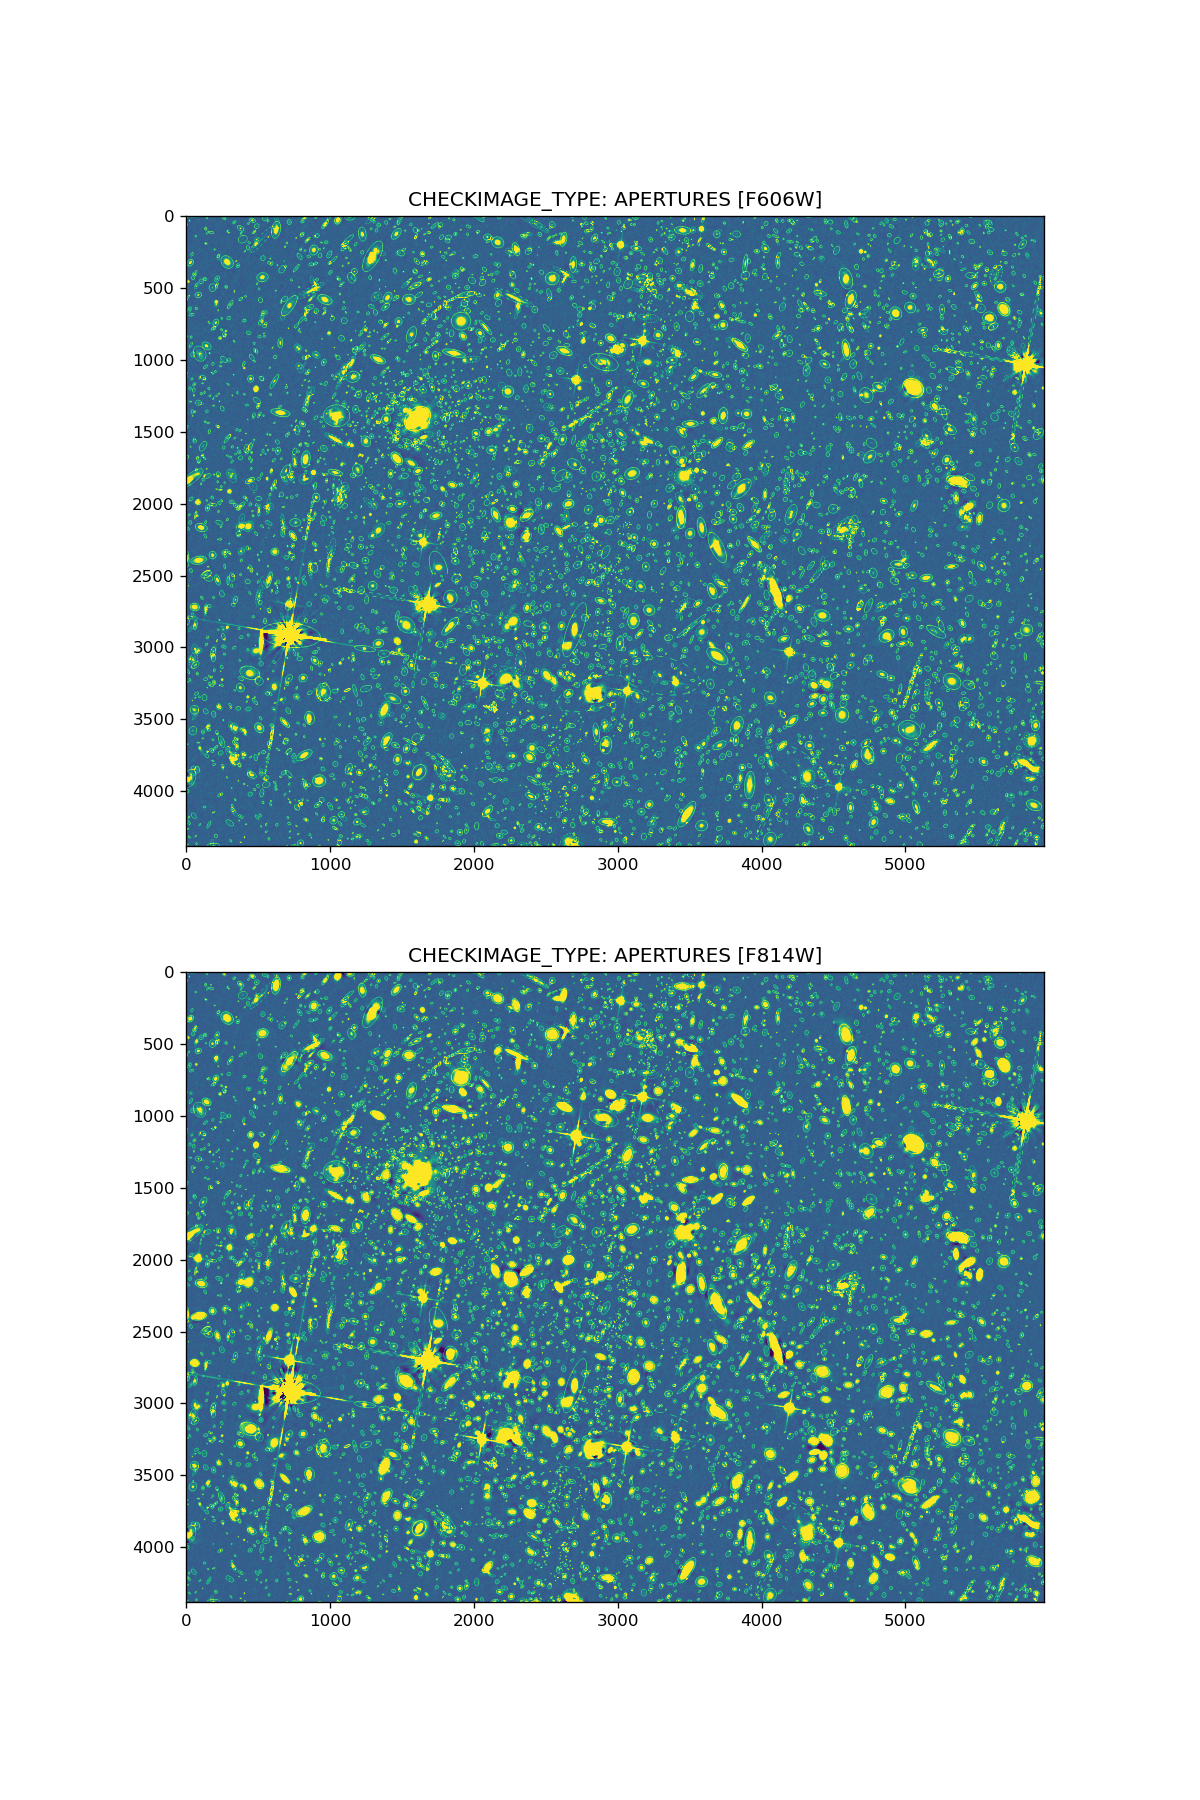

In [17]:
hdu_606_check = fits.open('./606_aper.fits')
hdu_814_check = fits.open('./814_aper.fits')

interval = ZScaleInterval()
vmin_606_check, vmax_606_check = interval.get_limits(hdu_606_check[0].data)
vmin_814_check, vmax_814_check = interval.get_limits(hdu_814_check[0].data)

fig, axes = plt.subplots(2,1, figsize=(10, 15))
axes[0].imshow(hdu_606_check[0].data, vmin=vmin_606_check, vmax=vmax_606_check)
axes[0].set_title('CHECKIMAGE_TYPE: APERTURES [F606W]')
axes[1].imshow(hdu_814_check[0].data, vmin=vmin_814_check, vmax=vmax_814_check)
axes[1].set_title('CHECKIMAGE_TYPE: APERTURES [F814W]')
plt.show()

In [18]:
dat = [dat_V, dat_I]

### 1) Magnitude - magnitude error diagram

<IPython.core.display.Javascript object>


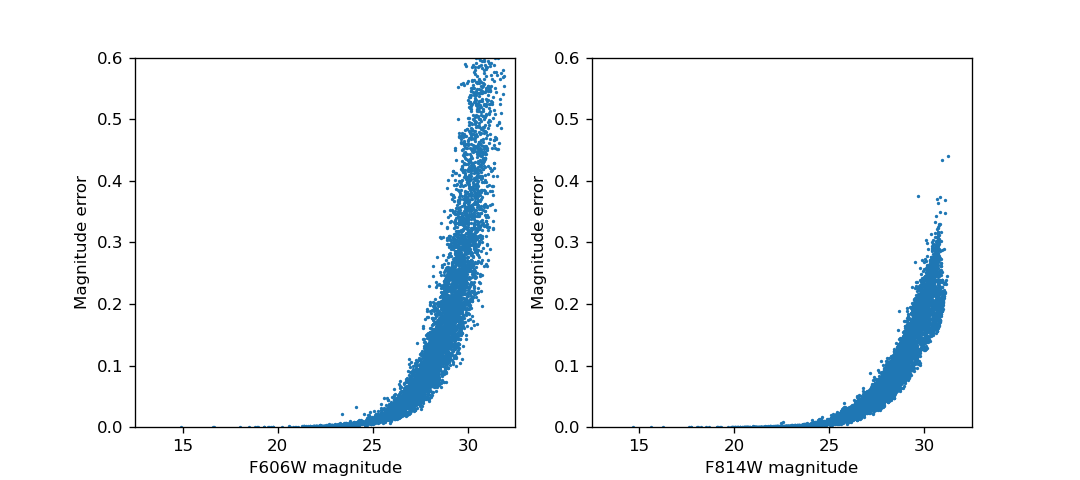

In [19]:
xlab = ["F606W magnitude", "F814W magnitude"]
ylab = ["Magnitude error"]

fig, axs = plt.subplots(1, 2, figsize=(9,4))
for i, ax in enumerate(axs):
    mag_range = (dat[i]['mag'] < 99.0)
    # magnitude of 99.0 means the source not detected in the 606-band image but detected in the 814-band image.
    ax.plot(dat[i]['mag'][mag_range], dat[i]['merr'][mag_range], 'o', ms=1)
    ax.set_xlim([12.5, 32.5])
    ax.set_ylim([0.0, 0.6])
    ax.set_xlabel(xlab[i])
    ax.set_ylabel(ylab[0])

### 2) Magnitude - stellarity (``CLASS_STAR``) digram

<IPython.core.display.Javascript object>


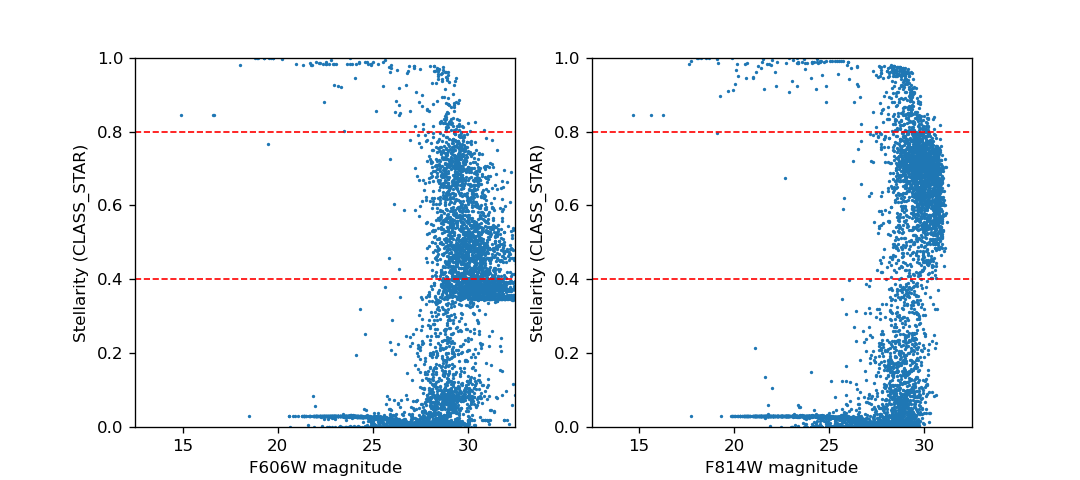

In [20]:
xlab = ["F606W magnitude", "F814W magnitude"]
ylab = ["Stellarity (CLASS_STAR)"]

fig, axs = plt.subplots(1, 2, figsize=(9,4))
for i, ax in enumerate(axs):
    mag_range = (dat[i]['mag'] < 99.0)
    # magnitude of 99.0 means the source not detected in the 606-band image but detected in the 814-band image.
    ax.plot(dat[i]['mag'][mag_range], dat[i]['cl'][mag_range], 'o', ms=1)
    ax.axhline(0.4, 0, 1, color='red', ls='--', lw=1)
    ax.axhline(0.8, 0, 1, color='red', ls='--', lw=1)
    # CLASS_STAR = 0.4 cut can also depend on the image quality, distribution of CLASS_STAR, or your scientific goals!
    ax.set_xlim([12.5, 32.5])
    ax.set_ylim([0.0, 1.0])
    ax.set_xlabel(xlab[i])
    ax.set_ylabel(ylab[0])

### From the above basic results, how can you select point/extended sources for analysis?

### 3) CMDs of galaxies (just for example!)

<IPython.core.display.Javascript object>


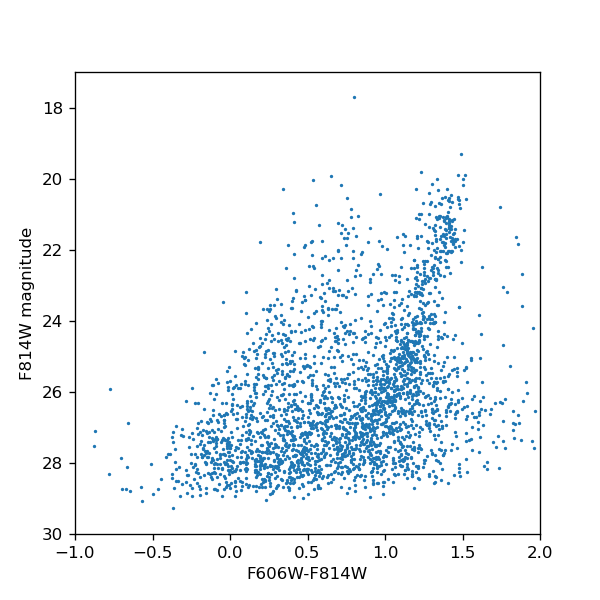

Text(0, 0.5, 'F814W magnitude')

In [21]:
gal_cnd = ((dat_V['mag'] < 30.0) & (dat_V['merr'] < 0.5) & (dat_I['mag'] < 30.0) & (dat_I['merr'] < 0.5) & \
           (dat_V['flxrad'] > 4.) & (dat_V['fwhm'] > 4.) & (dat_I['flxrad'] > 4.) & (dat_I['fwhm'] > 4.) & \
           (dat_V['mag']-dat_I['mag'] > -1.0) & (dat_V['mag']-dat_I['mag'] < 2.0) & \
           (dat_I['cl'] < 0.4))

xlab = ["F606W-F814W"]
ylab = ["F814W magnitude"]

fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.plot(dat_V['mag'][gal_cnd]-dat_I['mag'][gal_cnd], dat_I['mag'][gal_cnd], 'o', ms=1)
# ax.axhline(0.4, 0, 1, color='red', ls='--', lw=1)
# # CLASS_STAR = 0.4 cut can also depend on the image quality, distribution of CLASS_STAR, or your scientific goals!
ax.set_xlim([-1.0, 2.0])
ax.set_ylim([30.0, 17.0])
ax.set_xlabel(xlab[0])
ax.set_ylabel(ylab[0])